# Network Eigenstate

What's the final state a graph network $\mathcal{G}$ will settle in if provided with input $\vec{s}_0$ and an update euqation, and then left alone?

In [1]:
# Imports

import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import os,sys,math,itertools

import torch
import pandas as pd

from scipy import linalg as la

In [189]:
class GRAPH():
    def __init__(self,N,f=lambda x: x,energy=lambda x: np.linalg.norm(x),MAXHIST=10,norm_energy=1):
        # Parameters
        self.N = N
        # Weight matrix, bias and non-linearity
        self.W = rnd.randn(N,N)
        self.b = rnd.randn(N)
        self.f = f
        self.energy = energy
        # Init random state
        self.norm_energy = norm_energy
        self.s = rnd.randn(N)
        self.s = self.__normalize(self.s)
        self.e = self.energy(self.s)
        # State and energy history
        self.MAXHIST = MAXHIST
        self.S = []
        self.E = []
        self.S.append(self.s)
        self.E.append(self.e)
        # Return
        return
    def set_state(self,s):
        self.s = s
        self.s = self.__normalize(self.s)
        self.e = self.energy(self.s)
        self.__update_states_hist(s)
        self.__update_energy_hist(self.e)
        return
    def update(self,steps=1):
        for step in range(steps):
            self.s = self.f(np.dot(self.W,self.s) + self.b)
            self.s = self.__normalize(self.s)
            self.e = self.energy(self.s)
            self.__update_states_hist(self.s)
            self.__update_energy_hist(self.e)
        return
    def predict_k_steps_analytically(self,K):
        ev,EV = la.eig(self.W)
        Lamb = np.diag(ev**0)
        for k in range(1,K):
            Lamb += np.diag(ev**k)
        s_f = EV@(np.diag(ev**K)@np.linalg.inv(EV)@s0 + Lamb@np.linalg.inv(EV)@self.b)
        return s_f
    def __normalize(self,x):
        y = x
        if self.norm_energy>0:
            y /= self.energy(y)
            y *= self.norm_energy
        return y
    def __update_states_hist(self,x):
        self.S.append(x)
        if self.MAXHIST>0:
            if len(self.S)>self.MAXHIST: self.S = self.S[-self.MAXHIST:]
        return
    def __update_energy_hist(self,x):
        self.E.append(x)
        if self.MAXHIST>0:
            if len(self.E)>self.MAXHIST: self.E = self.E[-self.MAXHIST:]
        return

## Analytic Solution

For the update function $f(\vec{x})=\vec{x}$, the update equation for $\mathcal{G}$ after $N$ steps becomes
$$
    \vec{s}_{N} = \mathbf{W}^N\vec{s}_0 + \sum_{k=0}^N\mathbf{W}^k\vec{b}
$$
Eigendecomposition for $\mathbf{W}$ yields
$$
    \mathbf{W} = \mathbf{E}\mathbf{\Lambda}\mathbf{E}^{-1}\Rightarrow\mathbf{W}^N = \mathbf{E}\mathbf{\Lambda}^N\mathbf{E}^{-1}
$$
Therefore $\vec{s}_N$ can be written as
$$
    \vec{s}_N = \mathbf{E}\mathbf{\Lambda}^N\mathbf{E}^{-1}\vec{s}_0 + \sum_{k=0}^{N-1}\mathbf{E}\mathbf{\Lambda}^k\mathbf{E}^{-1}\vec{b}\Leftrightarrow\vec{s}_N = \mathbf{E}\mathbf{\Lambda}^N\mathbf{E}^{-1}\vec{s}_0 + \sum_{k=0}^{N-1}\mathbf{E}\mathbf{\Lambda}^k\mathbf{E}^{-1}\vec{b}
$$

The expanded version of this is

$$
\vec{s}_N = \mathbf{E}(\mathbf{\Lambda}^N\mathbf{E}^{-1}\vec{s}_0 + (\sum_{k=0}^{N-1}\mathbf{\Lambda}^k)\mathbf{E}^{-1}\vec{b})
$$

In [201]:
# Network setup

G = GRAPH(N=10,f = lambda x: x,norm_energy=-1)
#G_A = GRAPH(N=10,f = lambda x: (x>0).astype(int)*x)

In [203]:
K = 5

# Extract origin state
s0 = G.s

# Simulate
G.update(steps=K)
s_sim = G.s

# Calculate
ev,EV = la.eig(G.W)
Lamb = np.diag(ev**0)
for k in range(1,K):
    Lamb += np.diag(ev**k)
s_fc = EV@(np.diag(ev**K)@np.linalg.inv(EV)@s0 + Lamb@np.linalg.inv(EV)@G.b)

In [204]:
sf

array([ 604.10436883-5.07477128e-13j, -742.6344402 +4.24358804e-13j,
       -663.42780616+1.95592238e-13j,  385.17664048+9.61159591e-14j,
       -667.1607452 +3.75995317e-13j, -102.48061606-1.92135187e-13j,
       -638.22198613+4.38956672e-13j,  532.03687688-5.30936865e-14j,
       -158.53752271-1.77970581e-14j,  581.1354347 -1.70380985e-13j])

In [205]:
s_sim

array([ 604.10436883, -742.6344402 , -663.42780616,  385.17664048,
       -667.1607452 , -102.48061606, -638.22198613,  532.03687688,
       -158.53752271,  581.1354347 ])

In [196]:
G_nA.predict_k_steps_analytically(1)

array([ 1.69323788+2.06110839e-17j, -0.50533353-2.29866027e-18j,
        1.43326592+3.64498066e-16j, -0.10282102+1.84137235e-16j,
       -0.42933475-7.75494903e-17j,  0.82976383+6.77752541e-17j,
       -1.16373   -6.13169958e-17j,  0.99530108+2.11811999e-16j,
       -1.20853336-2.24466144e-16j,  0.38428803+3.48223102e-16j])

Including normalization:
$$
\vec{s}_{n+1} = \frac{\mathbf{W}\vec{s}_n + \vec{b}}{\left\|\mathbf{W}\vec{s}_n + \vec{b}\right\|}
$$

In [207]:
x = rnd.randn(3,2)

In [211]:
x

array([[ 0.95542747, -2.20372831],
       [ 0.31567935, -1.16770473],
       [ 0.62473614,  0.41977545]])

In [219]:
y = np.array([[2,1]])

In [220]:
y

array([[2, 1]])

In [221]:
np.einsum('ij,kj->ik',x,y)

array([[-0.29287338],
       [-0.53634603],
       [ 1.66924772]])

# Investigating stable energy states of the graph

In [51]:
# Network setup

G = GRAPH(N=25,MAXHIST=250)

In [52]:
G.update(steps=50)

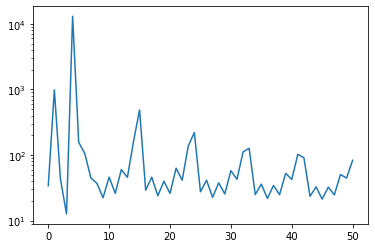

In [58]:
plt.semilogy(G.E)